In [2]:
# import packages
# load data set into appropriate variables

import numpy as np
import pandas as pd

df_movies = pd.read_csv('~/Downloads/ml-25m/movies.dat', sep='::', names=['MovieID','Title','Genres'], engine='python', encoding='latin-1', header=None)
df_ratings = pd.read_csv('~/Downloads/ml-25m/ratings.dat', sep='::', names=['UserID','MovieID','Rating', 'Timestamp'], parse_dates=['Timestamp'], engine='python', encoding='latin-1', header=None)
df_users = pd.read_csv('~/Downloads/ml-25m/users.dat', sep='::', names=['UserID','Gender','Age', 'Occupation', 'zip-code'], engine='python', encoding='latin-1', header=None)


In [3]:
# Data pre processing

# The data set was in good shape when I downloaded it, so it did not need any drastic corrections
# I ensured each entry/row was complete and correct using the techniques below
# I removed 2 columns I would not need and would cause conflicts during the linear regression done later
# I also added 2 columns that would help in my analysis
# The code below is well commented on what I did to achieve this

# Check for null/NaN values in the data sets
movies_nan_count = df_movies.isnull().sum()
ratings_nan_count = df_ratings.isnull().sum()
users_nan_count = df_users.isnull().sum()

print('Movies null values: ')
print(movies_nan_count)

print()

print('Ratings null values: ')
print(ratings_nan_count)

print()

print('Users null values: ')
print(users_nan_count)

# Movies null values: 
# MovieID    0
# Title      0
# Genres     0
# dtype: int64

# Ratings null values: 
# UserID       0
# MovieID      0
# Rating       0
# Timestamp    0
# dtype: int64

# Users null values: 
# UserID        0
# Gender        0
# Age           0
# Occupation    0
# zip-code      0
# dtype: int64

# As can be seen, there are no null/NaN values in the data
# No corrections need to be made here

# We need to combine the data sets into 1 data frame for further processing
df_movies_ratings = pd.merge(df_movies, df_ratings, on='MovieID')
df_movies_ratings_users = pd.merge(df_movies_ratings, df_users, on='UserID')

# Add a new feature called 'Average rating' to examine the rating each movie has
df_final = pd.DataFrame()
df_final['Average movie rating'] = pd.DataFrame(df_movies_ratings_users.groupby('Title')['Rating'].mean())

# Add a new feature called 'Total ratings' to examine how many ratings each movie has
df_final['Total movie ratings'] = pd.DataFrame(df_movies_ratings_users.groupby('Title')['Rating'].count())

# # Remove outliers
print()
print(df_final['Total movie ratings'].describe())

# count   58958.000
# mean      424.032
# std      2479.745
# min         1.000
# 25%         2.000
# 50%         6.000
# 75%        36.750
# max     81491.000

# Remove movies that do not have enough ratings (based on values from describe() above)
minimum_ratings = 5
df_final = df_final[df_final['Total movie ratings'] >= minimum_ratings]

df_final = df_final.merge(df_movies_ratings_users, left_on = 'Title', right_on = 'Title', how = 'left')

# Remove unnecessary features
remove_features = ['zip-code', 'Timestamp']
df_final.drop(remove_features, axis = 1, inplace = True)

# This concludes the data pre processing phase
# We have now a data set (saved in 'df_final') that has:
# 1. no null/NaN (incomplete) values 
# 2. no noisy (outlier) values (all movies with less than 5 ratings were removed)
# 3. 2 new/extra features: 'Average movie rating' + 'Total movie ratings'
# 4. Removed unnecessary features not used in analysis ('zip-code' + 'Timestamp') 


Movies null values: 
MovieID    0
Title      0
Genres     0
dtype: int64

Ratings null values: 
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

Users null values: 
UserID        0
Gender        0
Age           0
Occupation    0
zip-code      0
dtype: int64

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: Total movie ratings, dtype: float64


In [4]:
# Model selection

# I created 2 models here: Linear Regression + kNN models
# Linear regression: predict how well a user will enjoy a movie based on their age and occupation (largest 2 factors that determine movie rating found in preprocessing phase)
    # I used a sample size of 5K ratings from the total amount of samples to increase speed
# kNN: finds the closest related movies to a given movie
# The code below is well commented on what I did to achieve this

# Model 1: Linear Regression (used for prediction of rating/how well a user might like a movie)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df_final_sample = df_final.sample(n = 50000, random_state = 0)

# Based on preprocessing, the top 2 features that impact movie rating are age + occupation, exclude other features
exclude_features = ['Title', 'Genres', 'Gender', 'Average movie rating', 'Total movie ratings']
df_final_sample.drop(exclude_features, axis = 1, inplace = True)

data = df_final_sample.drop('Rating', axis = 1)
target = df_final_sample['Rating']

# split the data into train/test (80/20)
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.20, random_state = 0)

linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)

# Model 2: kNN (used to find related movies)
# Referenced this article: https://blog.jovian.ai/creating-a-movie-recommendation-system-using-python-5ba88a7eb6df
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

pivot_table = df_final.pivot_table(index='Title', columns='UserID', values='Rating').fillna(0)
pivot_table_matrix = csr_matrix(pivot_table.values)

knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn.fit(pivot_table_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [8]:
# Model evaluation

# The code below is well commented on what I did to achieve this

# Model 1: Linear Regression (used for prediction of rating/how well a user might like a movie)
# Model 1 (Linear Regression) Evaluation:
#     Mean Abs Error  MAE:  0.9394927445651309
#     Mean Sq Error  MSE:  1.2776115680903959
#     Root Mean Sq Error RMSE: 1.1303148092856237
from sklearn import metrics

y_prediction = linear_regression.predict(x_test)

# https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606
print('Model 1 (Linear Regression) Evaluation: ')
print('    Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_prediction))
print('    Mean Square Error (MSE):', metrics.mean_squared_error(y_test, y_prediction))
print('    Root Mean Square Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_prediction)))

# Model 2: kNN (used to find related movies)
# Referenced this article: https://blog.jovian.ai/creating-a-movie-recommendation-system-using-python-5ba88a7eb6df
# Model 2 (kNN) Evaluation:
#     Related movies for: Kagemusha (1980)
#
#     1: Ran (1985) (0.6194074678239863)
#     2: Yojimbo (1961) (0.6673660272138465)
#     3: Dersu Uzala (1974) (0.6724510361956109)
#     4: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) (0.6870603567595611)
#     5: Sanjuro (1962) (0.7300721960326331)

random_movie_id = np.random.choice(pivot_table.shape[0])
neighbour_distances, neighbour_indexes = knn.kneighbors(pivot_table.iloc[random_movie_id, :].values.reshape(1, -1), n_neighbors = 6)

print()
print('Model 2 (kNN) Evaluation: ')
for i in range(0, len(neighbour_distances.flatten())):
  if i == 0:
    movie_title = pivot_table.index[random_movie_id]
    print('    Related movies for:', movie_title, '\n')
  else:
    related_movie_index = neighbour_indexes.flatten()[i]
    related_movie_title = pivot_table.index[related_movie_index]
    relation_distance = neighbour_distances.flatten()[i]
    print('    {0}: {1} ({2})'.format(i, related_movie_title, relation_distance))

Model 1 (Linear Regression) Evaluation: 
    Mean Absolute Error (MAE): 0.9394927445651309
    Mean Square Error (MSE): 1.2776115680903959
    Root Mean Square Error (RMSE): 1.1303148092856237

Model 2 (kNN) Evaluation: 
    Related movies for: Lawnmower Man, The (1992) 

    1: Robocop 2 (1990) (0.47465220270235253)
    2: Judge Dredd (1995) (0.4805027274572491)
    3: Stargate (1994) (0.4840053273756759)
    4: Johnny Mnemonic (1995) (0.48673153708813766)
    5: Lost in Space (1998) (0.5039311888517726)


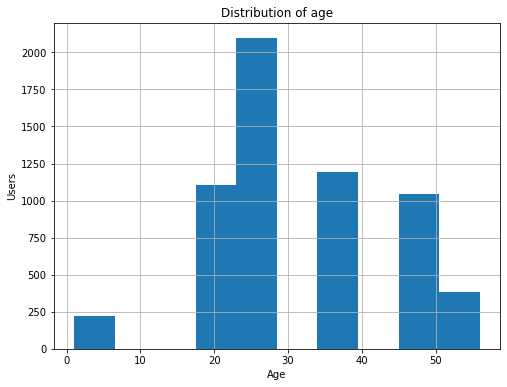

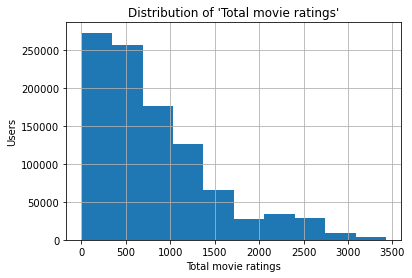

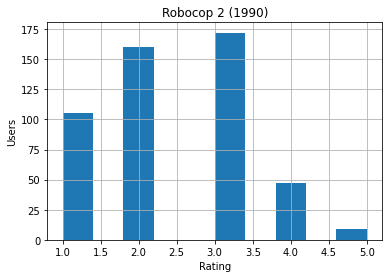

Model 1 (Linear Regression) Evaluation: 
    Mean Absolute Error (MAE): 0.9394927445651309
    Mean Square Error (MSE): 1.2776115680903959
    Root Mean Square Error (RMSE): 1.1303148092856237

Model 2 (kNN) Evaluation: 
    Related movies for: Malcolm X (1992) 

    1: Quiz Show (1994) (0.5927504181220473)
    2: People vs. Larry Flynt, The (1996) (0.5972994388265365)
    3: Boogie Nights (1997) (0.6099722491433801)
    4: Glengarry Glen Ross (1992) (0.6106312841879828)
    5: JFK (1991) (0.615343200261813)


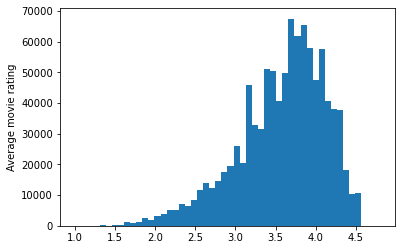

In [49]:
# Visualization of model performance or preprocessing

# Generated histograms, bar charts, displayed data from various samples of the data set for visualization
# Used to visualize data in the pre processing phase of analysis to better understand the data set and find any areas needed to be corrected
# Printed various data about the data set
# Visualized model performance/evaluation
# Any other figures that may be needed for the final report will be generated when writing the report
# The code below is well commented on what I did to achieve this

import matplotlib.pyplot as plt

figure_size = (8, 6)
plt.figure(figsize = figure_size)

# Distribution of age histogram
df_users.Age.hist()

plt.title('Distribution of age')
plt.xlabel('Age')
plt.ylabel('Users')

plt.show()

# Distribution of movie ratings by age histogram
df_final['Total movie ratings'].hist()

plt.title('Distribution of \'Total movie ratings\'')
plt.xlabel('Total movie ratings')
plt.ylabel('Users')

plt.show()

# Preprocessing analysis of a random movie 
movies_grouped = df_final.groupby('Title')
toy_story = movies_grouped.get_group('Robocop 2 (1990)')
toy_story['Rating'].hist()
plt.title('Robocop 2 (1990)')
plt.xlabel('Rating')
plt.ylabel('Users')

plt.show()

# Top 10 movies with the most ratings
most_ratings = df_final.groupby('Title')['Rating']
most_ratings = most_ratings.count().sort_values(ascending = False)
most_ratings[:10]

# Title
# American Beauty (1999)                                   3428
# Star Wars: Episode IV - A New Hope (1977)                2991
# Star Wars: Episode V - The Empire Strikes Back (1980)    2990
# Star Wars: Episode VI - Return of the Jedi (1983)        2883
# Jurassic Park (1993)                                     2672
# Saving Private Ryan (1998)                               2653
# Terminator 2: Judgment Day (1991)                        2649
# Matrix, The (1999)                                       2590
# Back to the Future (1985)                                2583
# Silence of the Lambs, The (1991)                         2578
# Name: Rating, dtype: int64

# Top 10 movies with the least ratings
least_ratings = df_final.groupby('Title')['Rating']
least_ratings = least_ratings.count().sort_values(ascending = True)
least_ratings[:10]

# Title
# Born American (1986)       5
# Delta of Venus (1994)      5
# Stag (1997)                5
# Cobra (1925)               5
# Enfer, L' (1994)           5
# Boys Life 2 (1997)         5
# Dancemaker (1998)          5
# Feast of July (1995)       5
# Frogs for Snakes (1998)    5
# In God's Hands (1998)      5
# Name: Rating, dtype: int64

# Average distribution of movie ratings
plt.hist(df_final['Average movie rating'], bins = 50)
plt.ylabel('Average movie rating')

# Evaluation Visualization
print('Model 1 (Linear Regression) Evaluation: ')
print('    Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_prediction))
print('    Mean Square Error (MSE):', metrics.mean_squared_error(y_test, y_prediction))
print('    Root Mean Square Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_prediction)))

random_movie_id = np.random.choice(pivot_table.shape[0])
neighbour_distances, neighbour_indexes = knn.kneighbors(pivot_table.iloc[random_movie_id, :].values.reshape(1, -1), n_neighbors = 6)

print()
print('Model 2 (kNN) Evaluation: ')
for i in range(0, len(neighbour_distances.flatten())):
  if i == 0:
    movie_title = pivot_table.index[random_movie_id]
    print('    Related movies for:', movie_title, '\n')
  else:
    related_movie_index = neighbour_indexes.flatten()[i]
    related_movie_title = pivot_table.index[related_movie_index]
    relation_distance = neighbour_distances.flatten()[i]
    print('    {0}: {1} ({2})'.format(i, related_movie_title, relation_distance))
